In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ucimlrepo import fetch_ucirepo
from scipy.stats import normaltest, levene, pointbiserialr, spearmanr

### Resumen del caso de estudio

El conjunto “Default of Credit Card Clients” agrupa 30 000 registros de clientes de tarjetas en Taiwán, con variables demográficas (sexo, educación, estado civil, edad), límite de crédito, seis meses de historial de pagos y montos facturados/pagados. Su propósito es analizar patrones que anticipen quién dejará de pagar al mes siguiente.

#### Objetivo del modelo

Formular un clasificador binario que prediga la variable Y (“default next month”: 1 = incumplimiento, 0 = pago), de modo que la entidad financiera pueda ajustar políticas de crédito, provisiones y cobros de forma proactiva.

#### Métrica objetivo: Recall de “incumplimiento de pago”

Maximizar el recall (TP / [TP + FN]) asegura detectar la mayor proporción posible de impagos reales. Dado que pasar por alto un incumplimiento genera pérdidas financieras directas muy superiores al coste de falsear un buen cliente, priorizar la sensibilidad es la estrategia más alineada con la gestión de riesgo crediticio.

In [2]:
# Accediendo al repositorio 

dccc = fetch_ucirepo(id=350)

# Accediendo a la información del dataset

data = dccc['data']

# Accediendo a las variables del dataset

df_dccc  = data['original']  # DataFrame con todas las variables + Y

# Mostrando las primeras filas del DataFrame

df_dccc.head(15)



,ID,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,2,2,2,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,1,3,2,35,-2,-2,-2,-2,...,0,13007,13912,0,0,0,13007,1122,0,0


In [3]:
# Renombrar las columnas del DataFrame para que sean más legibles


# Primero, definimos un diccionario con el mapeo de nombres:
renombrar = {
    'ID':    'cliente_id',
    'X1':    'monto_credito',               # Monto del crédito otorgado
    'X2':    'genero',                      # Género: 1=hombre, 2=mujer
    'X3':    'nivel_educacion',             # Educación: 1=posgrado,2=universidad,3=secundaria,4=otros
    'X4':    'estado_civil',                # 1=casado,2=soltero,3=otros
    'X5':    'edad',                        # Edad en años
    # Historial de pagos: septiembre a abril 2005
    'X6':    'pago_sep2005',                
    'X7':    'pago_ago2005',
    'X8':    'pago_jul2005',
    'X9':    'pago_jun2005',
    'X10':   'pago_may2005',
    'X11':   'pago_abr2005',
    # Montos de factura: septiembre a abril 2005
    'X12':   'factura_sep2005',
    'X13':   'factura_ago2005',
    'X14':   'factura_jul2005',
    'X15':   'factura_jun2005',
    'X16':   'factura_may2005',
    'X17':   'factura_abr2005',
    # Montos pagados: septiembre a abril 2005
    'X18':   'pagado_sep2005',
    'X19':   'pagado_ago2005',
    'X20':   'pagado_jul2005',
    'X21':   'pagado_jun2005',
    'X22':   'pagado_may2005',
    'X23':   'pagado_abr2005',
    'Y':     'incumplimiento'               # 1 = default, 0 = pago
}

# Aplica el renombrado
df_dccc = df_dccc.rename(columns=renombrar)

# Verifica el resultado
df_dccc.head(15)


,cliente_id,monto_credito,genero,nivel_educacion,estado_civil,edad,pago_sep2005,pago_ago2005,pago_jul2005,pago_jun2005,...,factura_jun2005,factura_may2005,factura_abr2005,pagado_sep2005,pagado_ago2005,pagado_jul2005,pagado_jun2005,pagado_may2005,pagado_abr2005,incumplimiento
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,2,2,2,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,1,3,2,35,-2,-2,-2,-2,...,0,13007,13912,0,0,0,13007,1122,0,0


In [4]:
# Inspeccionando dimensiones del DataFrame

df_dccc.shape

(30000, 25)

In [5]:
# Validando el tipo de datos de cada columna

df_dccc.dtypes

cliente_id         int64
monto_credito      int64
genero             int64
nivel_educacion    int64
estado_civil       int64
edad               int64
pago_sep2005       int64
pago_ago2005       int64
pago_jul2005       int64
pago_jun2005       int64
pago_may2005       int64
pago_abr2005       int64
factura_sep2005    int64
factura_ago2005    int64
factura_jul2005    int64
factura_jun2005    int64
factura_may2005    int64
factura_abr2005    int64
pagado_sep2005     int64
pagado_ago2005     int64
pagado_jul2005     int64
pagado_jun2005     int64
pagado_may2005     int64
pagado_abr2005     int64
incumplimiento     int64
dtype: object

In [6]:
# Identificando valores nulos en el DataFrame

df_dccc.isnull().sum()

cliente_id         0
monto_credito      0
genero             0
nivel_educacion    0
estado_civil       0
edad               0
pago_sep2005       0
pago_ago2005       0
pago_jul2005       0
pago_jun2005       0
pago_may2005       0
pago_abr2005       0
factura_sep2005    0
factura_ago2005    0
factura_jul2005    0
factura_jun2005    0
factura_may2005    0
factura_abr2005    0
pagado_sep2005     0
pagado_ago2005     0
pagado_jul2005     0
pagado_jun2005     0
pagado_may2005     0
pagado_abr2005     0
incumplimiento     0
dtype: int64

In [7]:
# Identificando posibles valores duplicados en el DataFrame

df_dccc.duplicated().sum()

np.int64(0)

In [8]:
# Asignando nombres a las variables categóricas

# Crear copia del DataFrame original
df_limpio = df_dccc.copy(deep=True)

# Mapas para variables categóricas simples

map_genero = {
    1: 'hombre',
    2: 'mujer'
}
map_educacion = {
    1: 'posgrado',
    2: 'universidad',
    3: 'secundaria',
    4: 'otros'
}
map_estado_civil = {
    1: 'casado',
    2: 'soltero',
    3: 'otros'
}
map_incumplimiento = {
    0: 'no incumple',
    1: 'incumple'
}

# Aplicar mapeos simples sobre la copia

df_limpio['genero']          = df_limpio['genero'].map(map_genero)
df_limpio['nivel_educacion'] = df_limpio['nivel_educacion'].map(map_educacion)
df_limpio['estado_civil']    = df_limpio['estado_civil'].map(map_estado_civil)
df_limpio['incumplimiento']  = df_limpio['incumplimiento'].map(map_incumplimiento)

# Mapa completo para historial de pagos (X6–X11)
#    –2 = muy adelantado; –1 = pago puntual; 0 = pago pendiente; ≥1 = retraso X mes(es)
map_historial_pago = {
    -2: 'pago adelantado',
    -1: 'pago puntual',
     0: 'pago pendiente'
}
# Añadimos dinámicamente etiquetas de retrasos de 1 a 9 meses

map_historial_pago.update({
    i: f'retraso {i} mes{"es" if i > 1 else ""}'
    for i in range(1, 10)
})

cols_hist = [
    'pago_sep2005', 'pago_ago2005', 'pago_jul2005',
    'pago_jun2005', 'pago_may2005', 'pago_abr2005'
]

# Aplicar mapeo y rellenar valores no contemplados en la copia

for col in cols_hist:
    df_limpio[col] = (
        df_limpio[col]
        .map(map_historial_pago)
        .fillna('otro/valor inválido', inplace=False)
    )

# 6) Verificación del inicio de df_limpio

df_limpio.head(15)

,cliente_id,monto_credito,genero,nivel_educacion,estado_civil,edad,pago_sep2005,pago_ago2005,pago_jul2005,pago_jun2005,...,factura_jun2005,factura_may2005,factura_abr2005,pagado_sep2005,pagado_ago2005,pagado_jul2005,pagado_jun2005,pagado_may2005,pagado_abr2005,incumplimiento
0,1,20000,mujer,universidad,casado,24,retraso 2 meses,retraso 2 meses,pago puntual,pago puntual,...,0,0,0,0,689,0,0,0,0,incumple
1,2,120000,mujer,universidad,soltero,26,pago puntual,retraso 2 meses,pago pendiente,pago pendiente,...,3272,3455,3261,0,1000,1000,1000,0,2000,incumple
2,3,90000,mujer,universidad,soltero,34,pago pendiente,pago pendiente,pago pendiente,pago pendiente,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,no incumple
3,4,50000,mujer,universidad,casado,37,pago pendiente,pago pendiente,pago pendiente,pago pendiente,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,no incumple
4,5,50000,hombre,universidad,casado,57,pago puntual,pago pendiente,pago puntual,pago pendiente,...,20940,19146,19131,2000,36681,10000,9000,689,679,no incumple
5,6,50000,hombre,posgrado,soltero,37,pago pendiente,pago pendiente,pago pendiente,pago pendiente,...,19394,19619,20024,2500,1815,657,1000,1000,800,no incumple
6,7,500000,hombre,posgrado,soltero,29,pago pendiente,pago pendiente,pago pendiente,pago pendiente,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,no incumple
7,8,100000,mujer,universidad,soltero,23,pago pendiente,pago puntual,pago puntual,pago pendiente,...,221,-159,567,380,601,0,581,1687,1542,no incumple
8,9,140000,mujer,secundaria,casado,28,pago pendiente,pago pendiente,retraso 2 meses,pago pendiente,...,12211,11793,3719,3329,0,432,1000,1000,1000,no incumple
9,10,20000,hombre,secundaria,soltero,35,pago adelantado,pago adelantado,pago adelantado,pago adelantado,...,0,13007,13912,0,0,0,13007,1122,0,no incumple


In [9]:
# Tipos de datos de cada columna

print("\n>>> TIPOS DE DATOS:")

df_limpio.dtypes


>>> TIPOS DE DATOS:


cliente_id          int64
monto_credito       int64
genero             object
nivel_educacion    object
estado_civil       object
edad                int64
pago_sep2005       object
pago_ago2005       object
pago_jul2005       object
pago_jun2005       object
pago_may2005       object
pago_abr2005       object
factura_sep2005     int64
factura_ago2005     int64
factura_jul2005     int64
factura_jun2005     int64
factura_may2005     int64
factura_abr2005     int64
pagado_sep2005      int64
pagado_ago2005      int64
pagado_jul2005      int64
pagado_jun2005      int64
pagado_may2005      int64
pagado_abr2005      int64
incumplimiento     object
dtype: object

In [10]:
# Estadísticas descriptivas de variables numéricas

num_df = df_limpio.select_dtypes(include='number').drop(columns=['cliente_id'])


desc = num_df.describe().T
desc['skewness'] = num_df.skew()
desc['kurtosis'] = num_df.kurtosis()
stats = desc.T

print("\n>>> ESTADÍSTICAS DESCRIPTIVAS (numéricas) + Skewness & Kurtosis:")
display(stats)


>>> ESTADÍSTICAS DESCRIPTIVAS (numéricas) + Skewness & Kurtosis:


,monto_credito,edad,factura_sep2005,factura_ago2005,factura_jul2005,factura_jun2005,factura_may2005,factura_abr2005,pagado_sep2005,pagado_ago2005,pagado_jul2005,pagado_jun2005,pagado_may2005,pagado_abr2005
count,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.681500,4826.076867,4799.387633,5215.502567
std,129747.661567,9.217904,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.961470,15666.159744,15278.305679,17777.465775
min,10000.000000,21.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.000000,296.000000,252.500000,117.750000
50%,140000.000000,34.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.000000,1500.000000,1500.000000,1500.000000
75%,240000.000000,41.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.000000,4013.250000,4031.500000,4000.000000
max,1000000.000000,79.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000
skewness,0.992867,0.732246,2.663861,2.705221,3.087830e+00,2.821965,2.876380,2.846645,14.668364,3.045382e+01,17.216635,12.904985,11.127417,10.640727
kurtosis,0.536263,0.044303,9.806289,10.302946,1.978326e+01,11.309325,12.305881,12.270705,415.254743,1.641632e+03,564.311229,277.333768,180.063940,167.161430


In [11]:
# Estadísticas descriptivas de variables categóricas

print("\n>>> RESUMEN DE CATEGÓRICAS:")
df_limpio.describe(include=['object'])


>>> RESUMEN DE CATEGÓRICAS:


,genero,nivel_educacion,estado_civil,pago_sep2005,pago_ago2005,pago_jul2005,pago_jun2005,pago_may2005,pago_abr2005,incumplimiento
count,30000,29655,29946,30000,30000,30000,30000,30000,30000,30000
unique,2,4,3,11,11,11,11,10,10,2
top,mujer,universidad,soltero,pago pendiente,pago pendiente,pago pendiente,pago pendiente,pago pendiente,pago pendiente,no incumple
freq,18112,14030,15964,14737,15730,15764,16455,16947,16286,23364



>>> DISTRIBUCIÓN DE LA VARIABLE OBJETIVO:
incumplimiento
no incumple    23364
incumple        6636
Name: count, dtype: int64


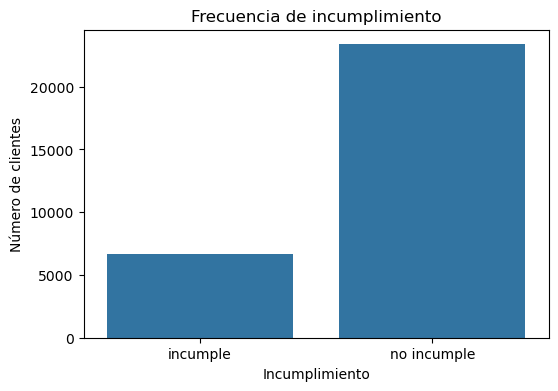

In [12]:
# Distribución de la variable objetivo 'incumplimiento'

print("\n>>> DISTRIBUCIÓN DE LA VARIABLE OBJETIVO:")
print(df_limpio['incumplimiento'].value_counts(dropna=False))
plt.figure(figsize=(6,4))
sns.countplot(x='incumplimiento', data=df_limpio)
plt.title("Frecuencia de incumplimiento")
plt.xlabel("Incumplimiento")
plt.ylabel("Número de clientes")
plt.show()

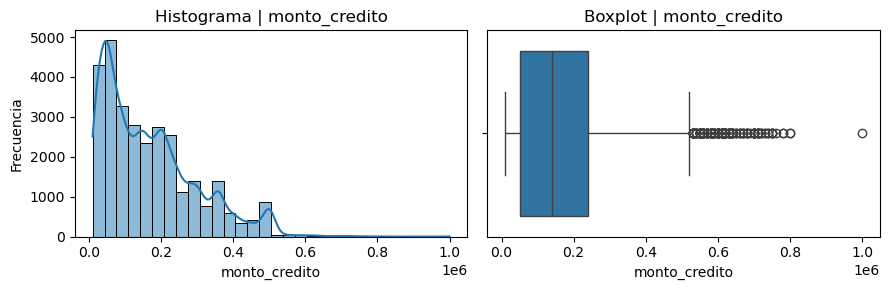

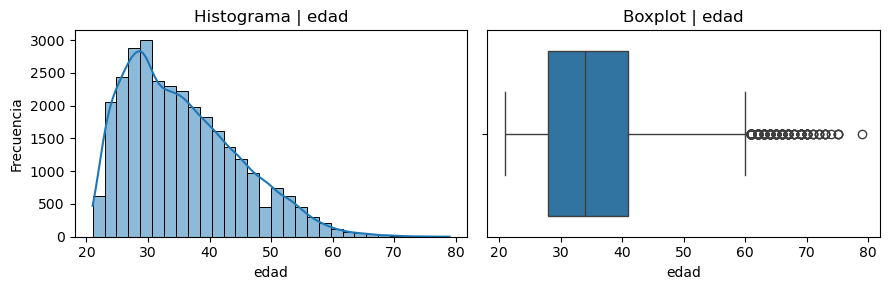

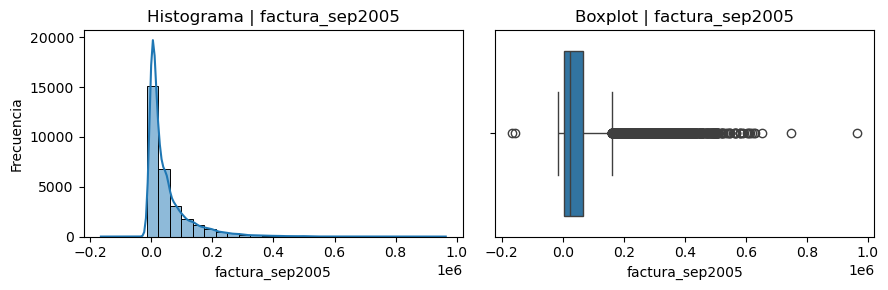

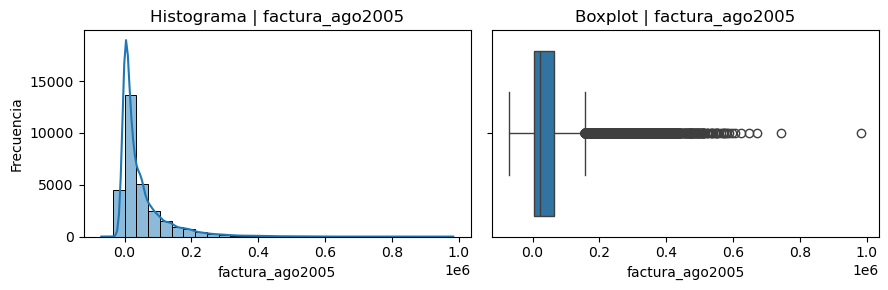

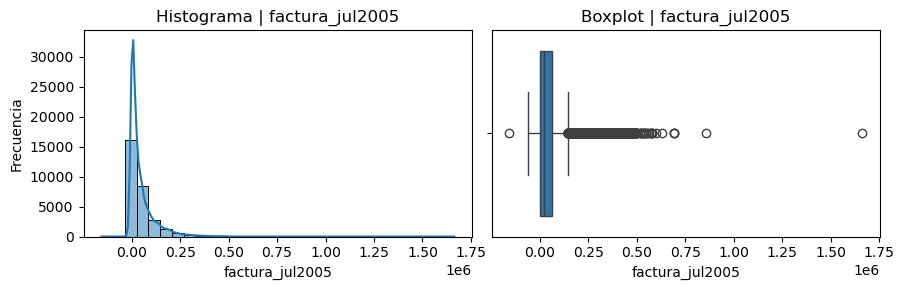

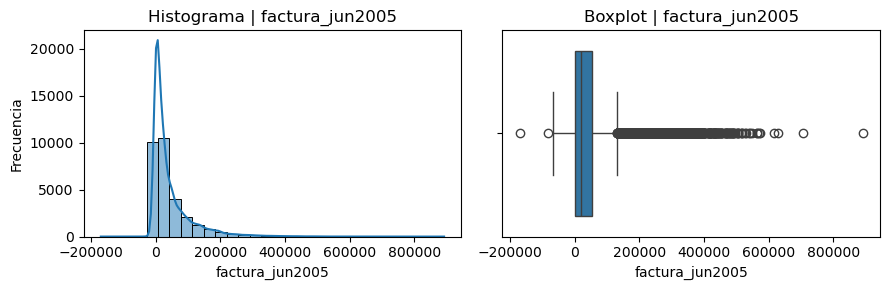

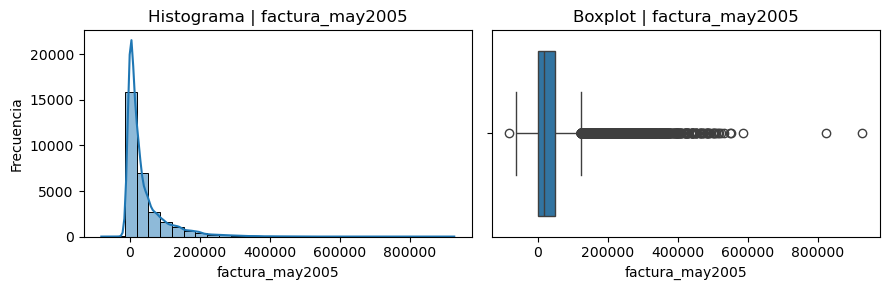

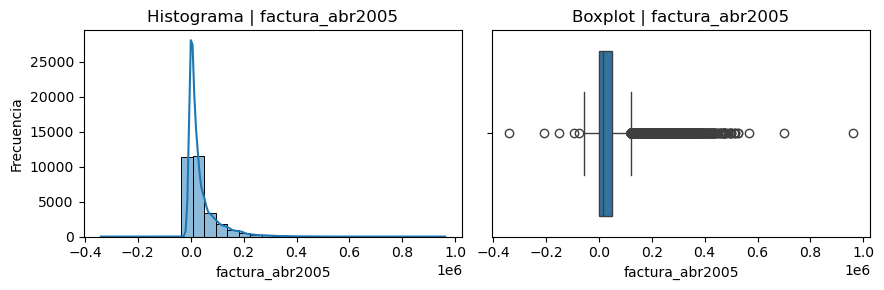

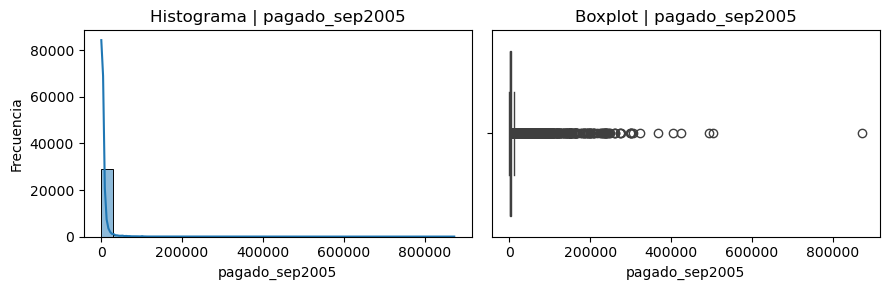

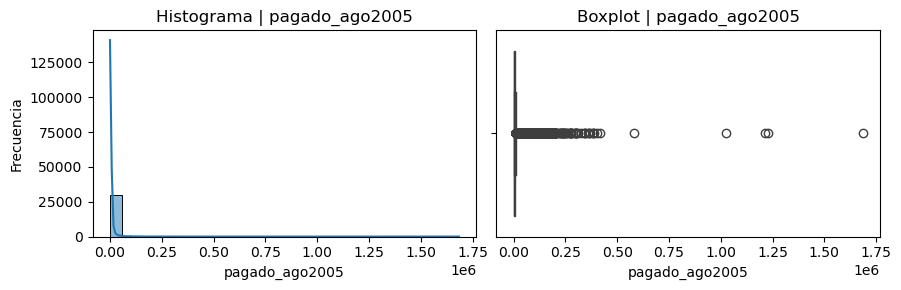

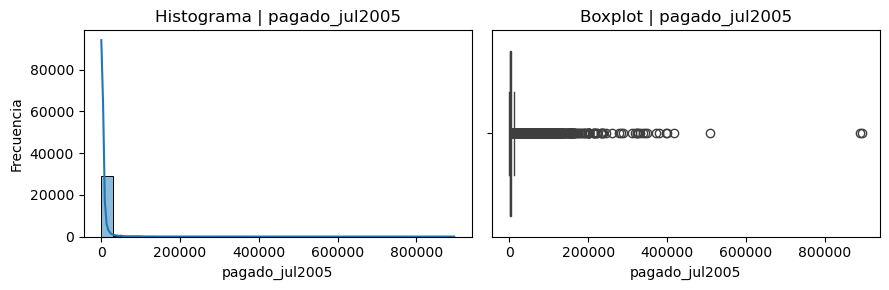

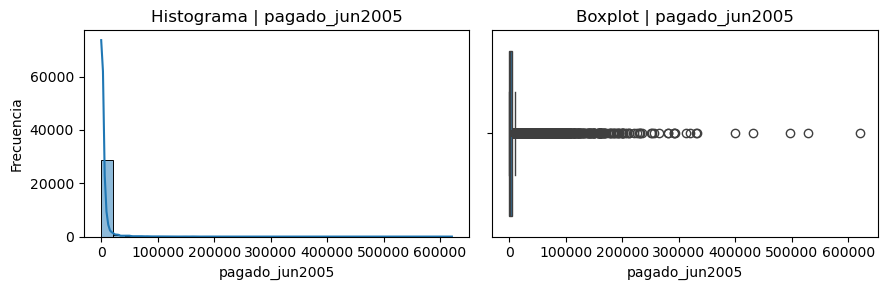

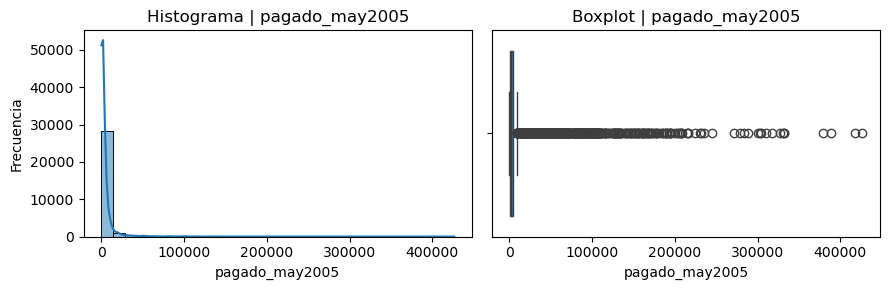

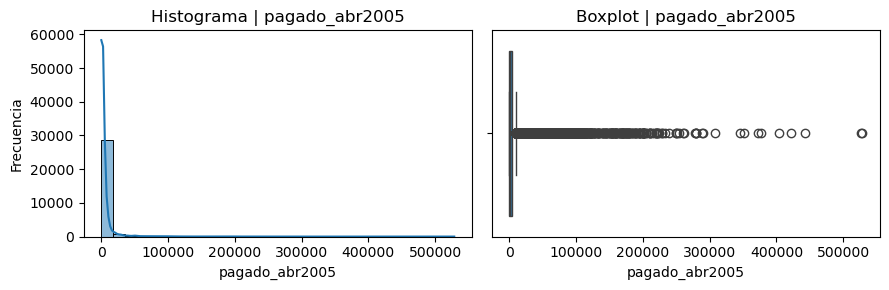

In [13]:
# Análisis univariado de variables numéricas

# Separando variable objetivo

y = df_limpio['incumplimiento']                            # target
X = df_limpio.drop(columns=['incumplimiento','cliente_id']) # resto de variables

# Seleccionando todas las columnas numéricas
num_vars = X.select_dtypes(include='number').columns

# Bucle de visualización

for col in num_vars:
    # Crear figura con histograma + boxplot en la misma fila
    fig, axes = plt.subplots(1, 2, figsize=(9, 3))
    
    # Histograma con KDE
    sns.histplot(X[col], bins=30, kde=True, ax=axes[0])
    axes[0].set_title(f'Histograma | {col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frecuencia')
    
    # Boxplot horizontal
    sns.boxplot(x=X[col], ax=axes[1])
    axes[1].set_title(f'Boxplot | {col}')
    axes[1].set_xlabel(col)
    
    plt.tight_layout()
    plt.show()

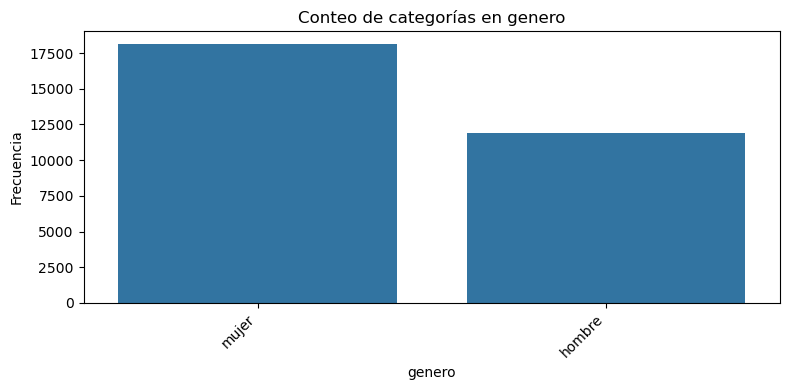

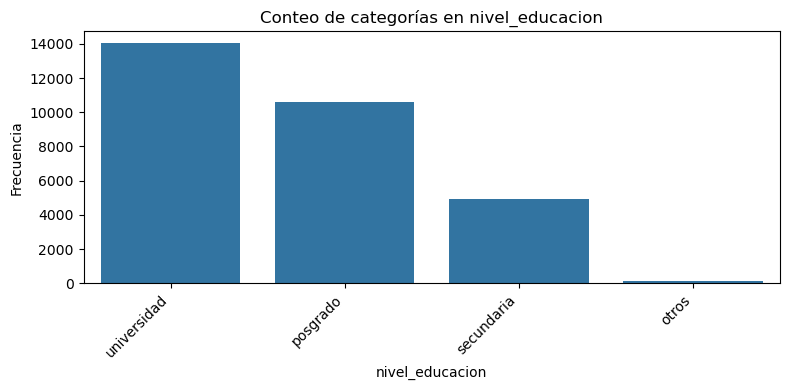

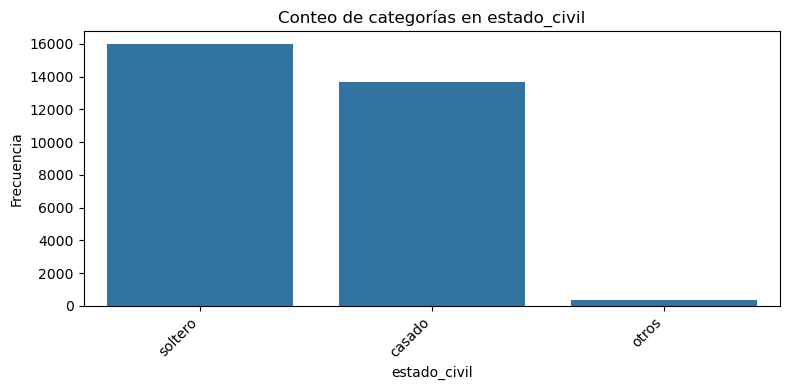

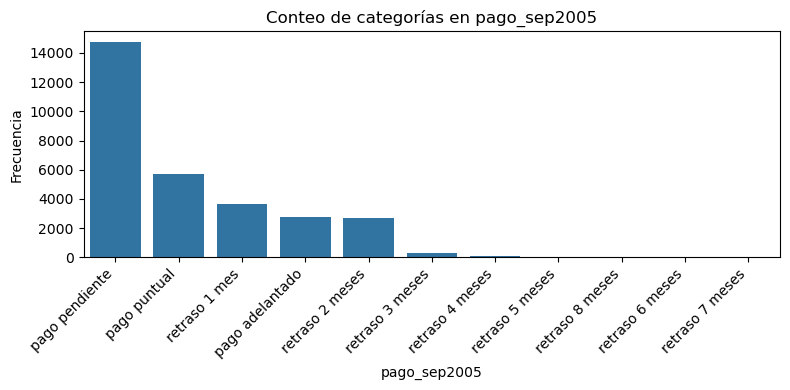

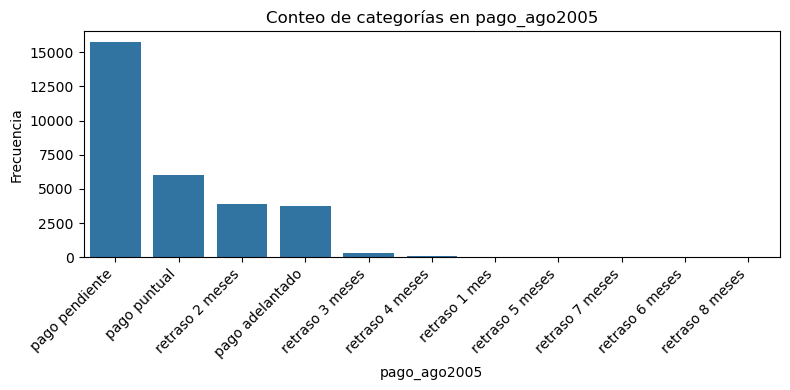

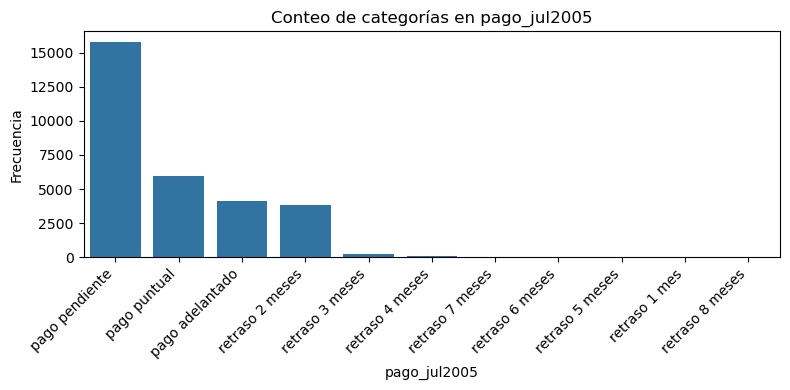

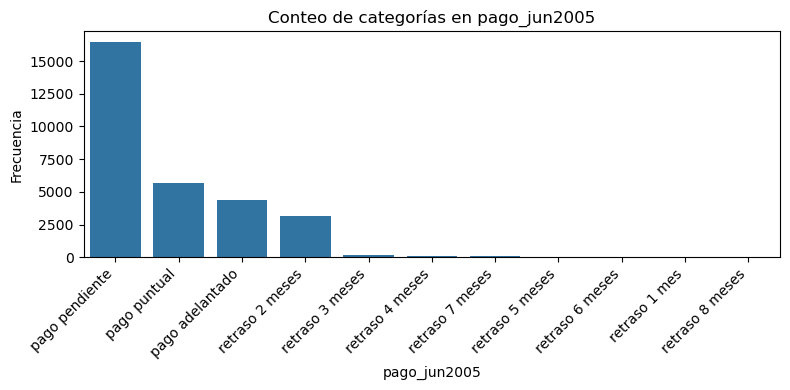

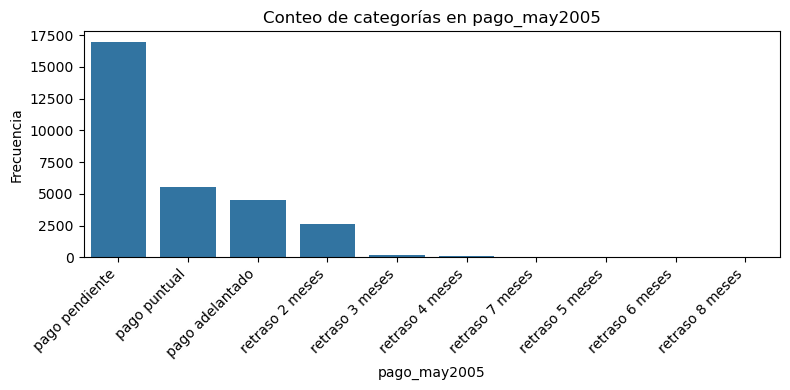

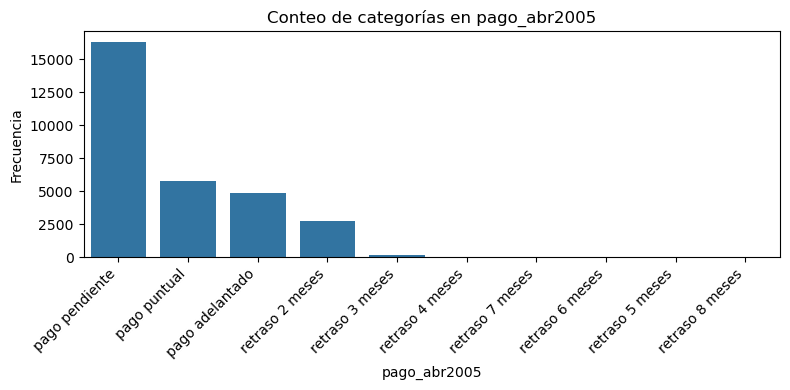

In [14]:
# Análisis univariado categórico

# Seleccionar solo variables object y excluir 'incumplimiento'

cat_vars = df_limpio.select_dtypes(include='object') \
                    .columns.drop('incumplimiento')

for col in cat_vars:
    plt.figure(figsize=(8, 4))
    sns.countplot(
        x=col,
        data=df_limpio,
        order=df_limpio[col].value_counts().index
    )
    plt.title(f'Conteo de categorías en {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45, ha='right')     # Girar etiquetas para evitar solapamiento
    plt.tight_layout()                       # Ajusta márgenes automáticamente
    plt.show()

In [15]:
# Validando cardinalidad y detección de niveles raros en variables categóricas

# Seleccionamos columnas de tipo object y quitamos únicamente la variable objetivo

cat_vars = df_limpio.select_dtypes(include='object') \
                    .columns.drop('incumplimiento')

for col in cat_vars:
    total = len(df_limpio)
    freq = df_limpio[col].value_counts(normalize=True)
    cardinalidad = df_limpio[col].nunique()
    raros = freq[freq < 0.01]
    
    print(f"\n>>> {col.upper()}")
    print(f"- Cardinalidad: {cardinalidad} niveles")
    print(f"- Niveles raros (<1%):")
    if raros.empty:
        print("  Ninguno")
    else:
        for nivel, proporcion in raros.items():
            print(f"  • {nivel}: {proporcion:.2%} de la muestra")



>>> GENERO
- Cardinalidad: 2 niveles
- Niveles raros (<1%):
  Ninguno

>>> NIVEL_EDUCACION
- Cardinalidad: 4 niveles
- Niveles raros (<1%):
  • otros: 0.41% de la muestra

>>> ESTADO_CIVIL
- Cardinalidad: 3 niveles
- Niveles raros (<1%):
  Ninguno

>>> PAGO_SEP2005
- Cardinalidad: 11 niveles
- Niveles raros (<1%):
  • retraso 4 meses: 0.25% de la muestra
  • retraso 5 meses: 0.09% de la muestra
  • retraso 8 meses: 0.06% de la muestra
  • retraso 6 meses: 0.04% de la muestra
  • retraso 7 meses: 0.03% de la muestra

>>> PAGO_AGO2005
- Cardinalidad: 11 niveles
- Niveles raros (<1%):
  • retraso 4 meses: 0.33% de la muestra
  • retraso 1 mes: 0.09% de la muestra
  • retraso 5 meses: 0.08% de la muestra
  • retraso 7 meses: 0.07% de la muestra
  • retraso 6 meses: 0.04% de la muestra
  • retraso 8 meses: 0.00% de la muestra

>>> PAGO_JUL2005
- Cardinalidad: 11 niveles
- Niveles raros (<1%):
  • retraso 3 meses: 0.80% de la muestra
  • retraso 4 meses: 0.25% de la muestra
  • retraso 7 me

In [16]:
# Columnas de historial de pago (ordinales)

pago_cols = [
    'pago_sep2005', 'pago_ago2005', 'pago_jul2005',
    'pago_jun2005', 'pago_may2005', 'pago_abr2005'
]

# Conversión segura a entero y truncado

df_dccc[pago_cols] = (
    df_dccc[pago_cols]
      .apply(pd.to_numeric, errors='coerce')      # fuerza numérico
      .clip(lower=-2, upper=8)                   # limpia outliers
      .clip(upper=3)                             # agrupa ≥3 meses
      .astype('int8')                            # reduce memoria
)


# Variables agregadas

# incidente más grave
df_dccc['max_retraso']  = df_dccc[pago_cols].max(axis=1)

# promedio de los 6 meses
df_dccc['prom_retraso'] = df_dccc[pago_cols].mean(axis=1)

# tendencia (aprox. pendiente): dot product ndarray · [0,1,2,3,4,5]

weights = np.arange(len(pago_cols), dtype='int8')   # 0‥5

df_dccc['tend_retraso'] = (
    df_dccc[pago_cols].to_numpy(dtype='int8') @ weights
) / 15.0                                            # normaliza


df_dccc.head(15)



,cliente_id,monto_credito,genero,nivel_educacion,estado_civil,edad,pago_sep2005,pago_ago2005,pago_jul2005,pago_jun2005,...,pagado_sep2005,pagado_ago2005,pagado_jul2005,pagado_jun2005,pagado_may2005,pagado_abr2005,incumplimiento,max_retraso,prom_retraso,tend_retraso
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,689,0,0,0,0,1,2,-0.333333,-1.400000
1,2,120000,2,2,2,26,-1,2,0,0,...,0,1000,1000,1000,0,2000,1,2,0.500000,0.800000
2,3,90000,2,2,2,34,0,0,0,0,...,1518,1500,1000,1000,1000,5000,0,0,0.000000,0.000000
3,4,50000,2,2,1,37,0,0,0,0,...,2000,2019,1200,1100,1069,1000,0,0,0.000000,0.000000
4,5,50000,1,2,1,57,-1,0,-1,0,...,2000,36681,10000,9000,689,679,0,0,-0.333333,-0.133333
5,6,50000,1,1,2,37,0,0,0,0,...,2500,1815,657,1000,1000,800,0,0,0.000000,0.000000
6,7,500000,1,1,2,29,0,0,0,0,...,55000,40000,38000,20239,13750,13770,0,0,0.000000,0.000000
7,8,100000,2,2,2,23,0,-1,-1,0,...,380,601,0,581,1687,1542,0,0,-0.500000,-0.533333
8,9,140000,2,3,1,28,0,0,2,0,...,3329,0,432,1000,1000,1000,0,2,0.333333,0.266667
9,10,20000,1,3,2,35,-2,-2,-2,-2,...,0,0,0,13007,1122,0,0,-1,-1.666667,-1.400000


In [17]:
# Verificando valores únicos de pago_cols

for col in pago_cols:
    print(f"\n>>> {col.upper()}")
    print(df_dccc[col].unique())
    print(f"Cardinalidad: {df_dccc[col].nunique()} niveles")
    


>>> PAGO_SEP2005
[ 2 -1  0 -2  1  3]
Cardinalidad: 6 niveles

>>> PAGO_AGO2005
[ 2  0 -1 -2  3  1]
Cardinalidad: 6 niveles

>>> PAGO_JUL2005
[-1  0  2 -2  3  1]
Cardinalidad: 6 niveles

>>> PAGO_JUN2005
[-1  0 -2  2  3  1]
Cardinalidad: 6 niveles

>>> PAGO_MAY2005
[-2  0 -1  2  3]
Cardinalidad: 5 niveles

>>> PAGO_ABR2005
[-2  2  0 -1  3]
Cardinalidad: 5 niveles


In [18]:
# Diccionarios de mapeo según documentación
map_genero = {
    1: 'hombre',
    2: 'mujer'
}
map_educacion = {
    1: 'posgrado',
    2: 'universidad',
    3: 'secundaria',
    4: 'otros',
}
map_estado_civil = {
    1: 'casado',
    2: 'soltero',
    3: 'otros',
}
map_incumplimiento = {
    0: 'no incumple',
    1: 'incumple'
}

# Aplicando mapeos sobre las columnas originales
df_dccc['genero']          = df_dccc['genero'].map(map_genero)
df_dccc['nivel_educacion'] = df_dccc['nivel_educacion'].map(map_educacion)
df_dccc['estado_civil']    = df_dccc['estado_civil'].map(map_estado_civil)

# Crear la versión texto de la variable objetivo directamente
df_dccc['incumplimiento_txt'] = df_dccc['incumplimiento'].map(map_incumplimiento)

# Verificar el resultado de los mapeos
df_dccc.head(15)


,cliente_id,monto_credito,genero,nivel_educacion,estado_civil,edad,pago_sep2005,pago_ago2005,pago_jul2005,pago_jun2005,...,pagado_ago2005,pagado_jul2005,pagado_jun2005,pagado_may2005,pagado_abr2005,incumplimiento,max_retraso,prom_retraso,tend_retraso,incumplimiento_txt
0,1,20000,mujer,universidad,casado,24,2,2,-1,-1,...,689,0,0,0,0,1,2,-0.333333,-1.400000,incumple
1,2,120000,mujer,universidad,soltero,26,-1,2,0,0,...,1000,1000,1000,0,2000,1,2,0.500000,0.800000,incumple
2,3,90000,mujer,universidad,soltero,34,0,0,0,0,...,1500,1000,1000,1000,5000,0,0,0.000000,0.000000,no incumple
3,4,50000,mujer,universidad,casado,37,0,0,0,0,...,2019,1200,1100,1069,1000,0,0,0.000000,0.000000,no incumple
4,5,50000,hombre,universidad,casado,57,-1,0,-1,0,...,36681,10000,9000,689,679,0,0,-0.333333,-0.133333,no incumple
5,6,50000,hombre,posgrado,soltero,37,0,0,0,0,...,1815,657,1000,1000,800,0,0,0.000000,0.000000,no incumple
6,7,500000,hombre,posgrado,soltero,29,0,0,0,0,...,40000,38000,20239,13750,13770,0,0,0.000000,0.000000,no incumple
7,8,100000,mujer,universidad,soltero,23,0,-1,-1,0,...,601,0,581,1687,1542,0,0,-0.500000,-0.533333,no incumple
8,9,140000,mujer,secundaria,casado,28,0,0,2,0,...,0,432,1000,1000,1000,0,2,0.333333,0.266667,no incumple
9,10,20000,hombre,secundaria,soltero,35,-2,-2,-2,-2,...,0,0,13007,1122,0,0,-1,-1.666667,-1.400000,no incumple


### Estadísticos descriptivos por grupo (mean, std, count):


monto_credito                     edad               \
                            mean        std  count   mean   std  count   
incumplimiento_txt                                                       
incumple               130109.66  115378.54   6636  35.73  9.69   6636   
no incumple            178099.73  131628.36  23364  35.42  9.08  23364   

                   pago_sep2005              pago_ago2005  ... pagado_abr2005  \
                           mean   std  count         mean  ...          count   
incumplimiento_txt                                         ...                  
incumple                   0.64  1.31   6636         0.43  ...           6636   
no incumple               -0.22  0.93  23364        -0.31  ...          23364   

                   max_retraso              prom_retraso               \
                          mean   std  count         mean   std  count   
incumplimiento_txt                                                      
incumple                  1.19  1.34   6636         0.30  1.15   6636   
no incumple               0.19  1.14  23364        -0.33  0.82  23364   

                   tend_retraso               
                           mean   std  count  
incumplimiento_txt                            
incumple                   0.17  1.22   6636  
no incumple               -0.38  0.87  23364  

[2 rows x 69 columns]

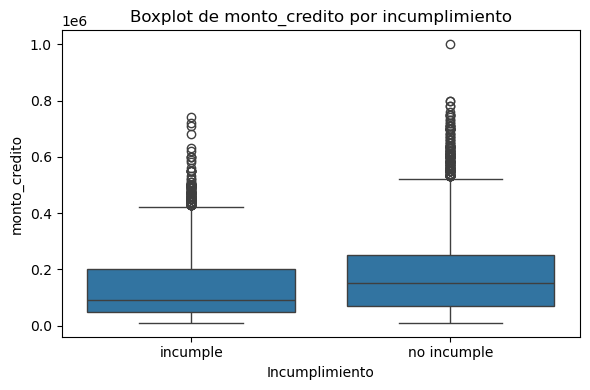

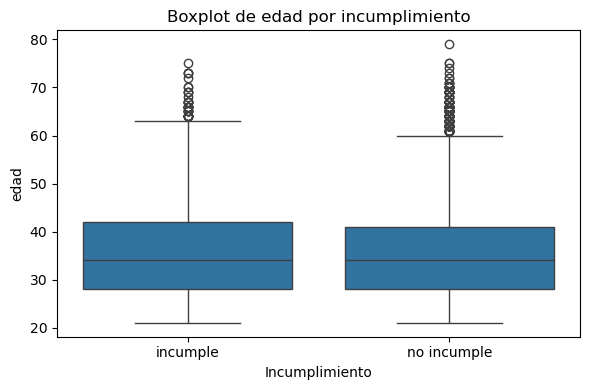

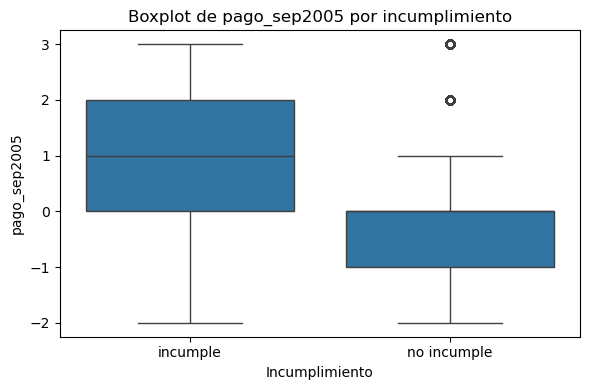

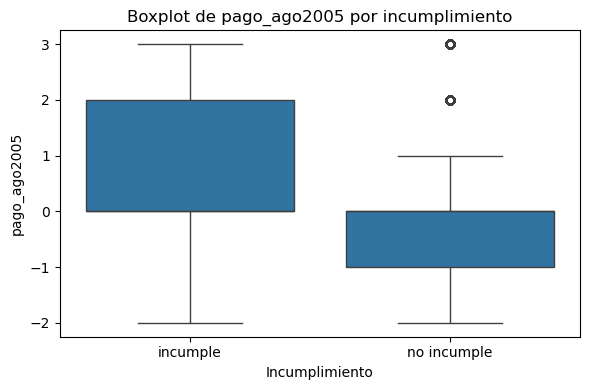

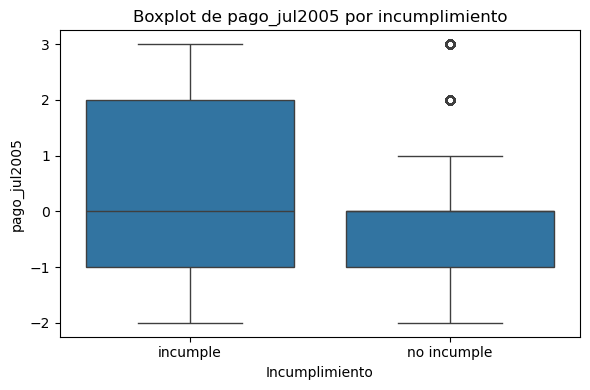

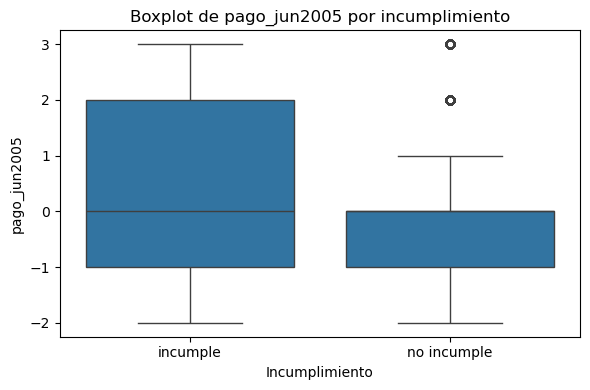

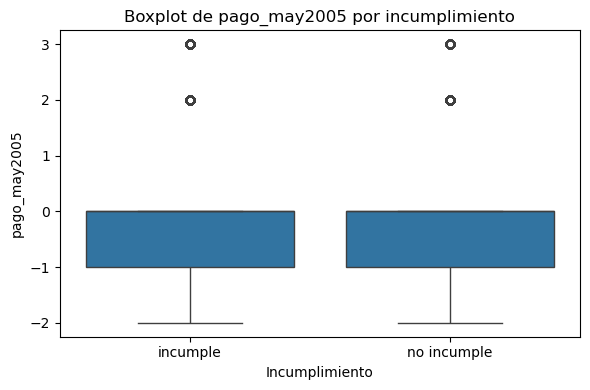

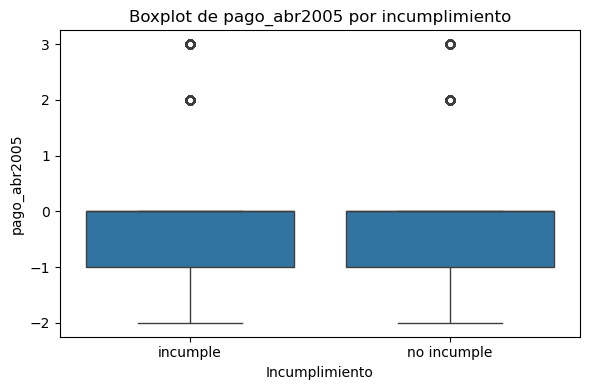

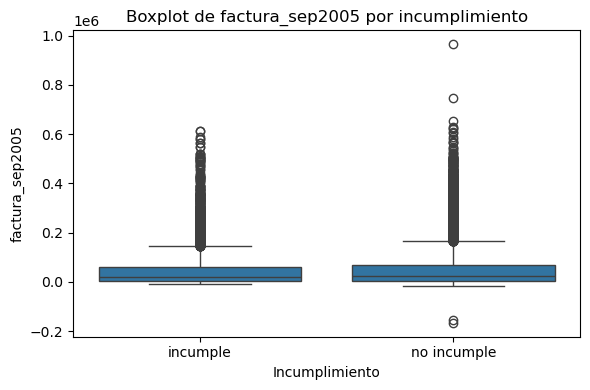

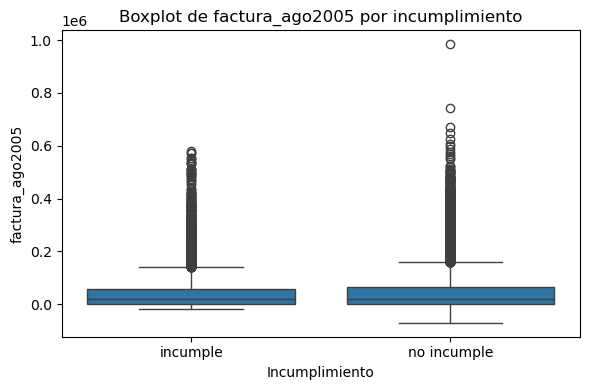

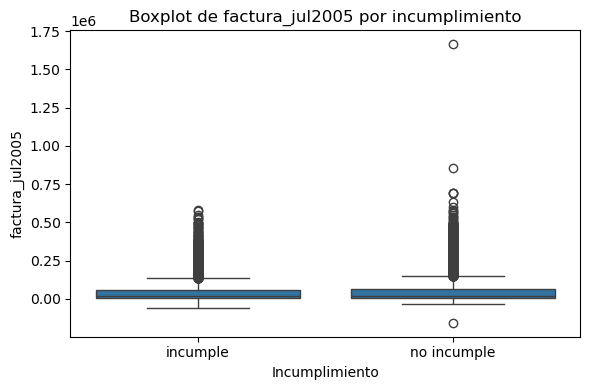

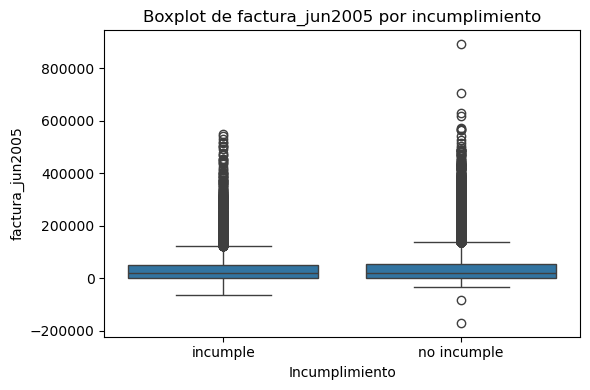

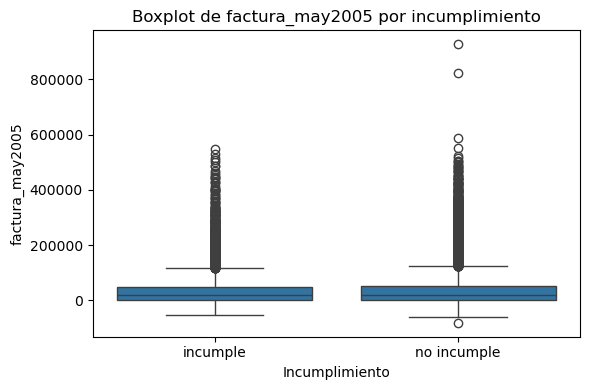

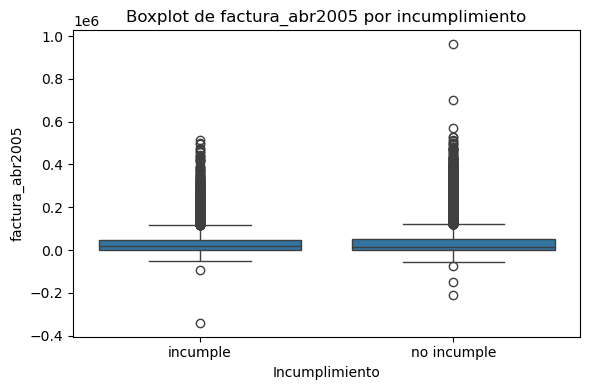

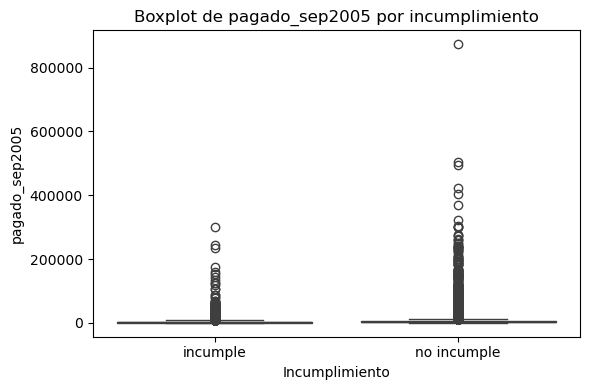

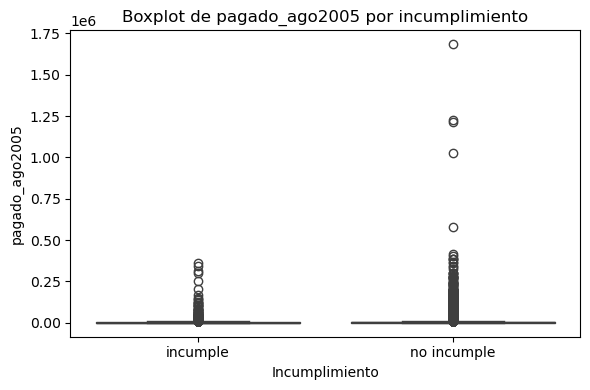

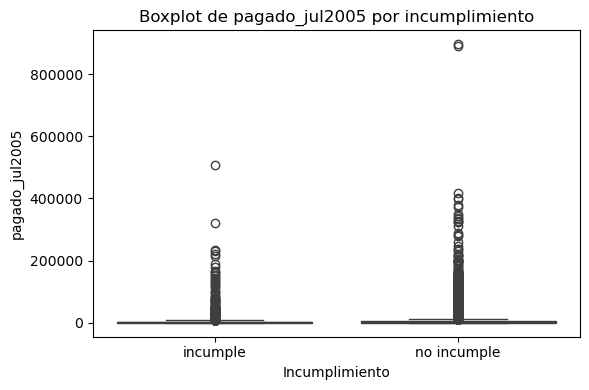

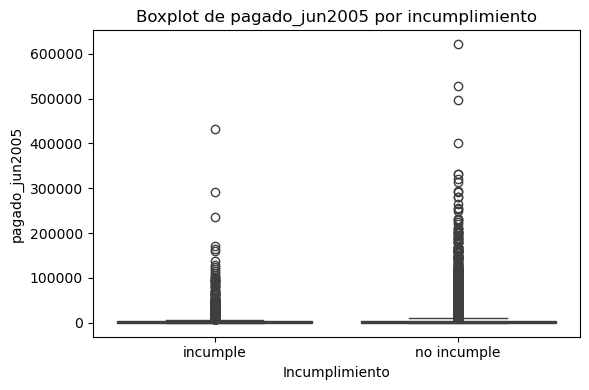

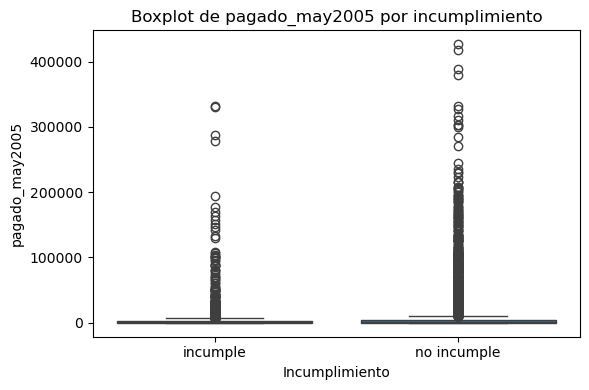

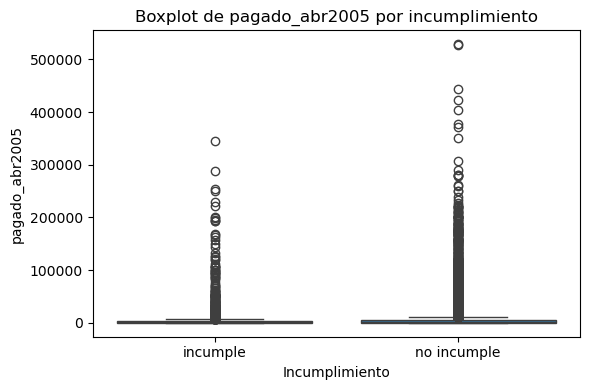

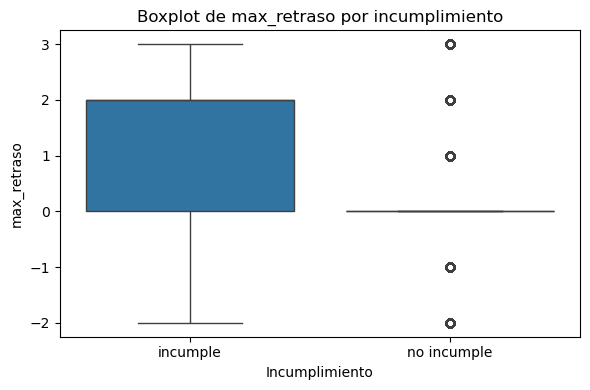

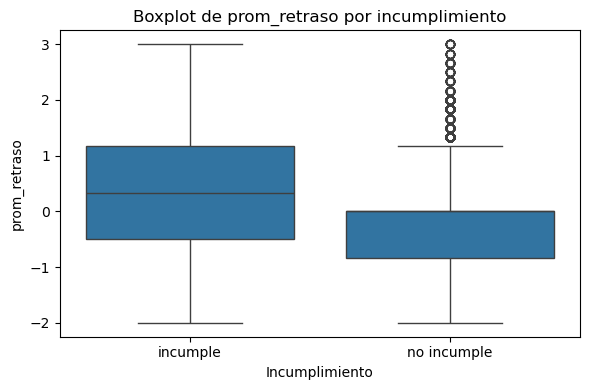

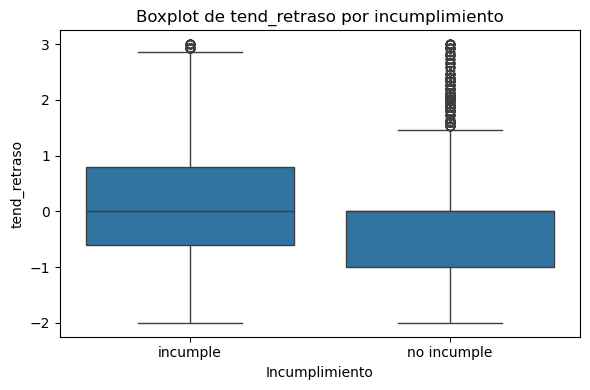

In [20]:
# Comparación de medias y dispersión por grupo de incumplimiento


# Identificar variables numéricas (excluyendo ID y target)
numeric_vars = df_dccc.select_dtypes(include='number') \
                     .columns.drop(['cliente_id', 'incumplimiento'])

# Estadísticos descriptivos por grupo (mean, std, count)
group_stats = (
    df_dccc
    .groupby('incumplimiento_txt')[numeric_vars]
    .agg(['mean', 'std', 'count'])
    .round(2)
)
print("### Estadísticos descriptivos por grupo (mean, std, count):")
display(group_stats)

# Visualización de dispersión con boxplots
for col in numeric_vars:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='incumplimiento_txt', y=col, data=df_dccc)
    plt.title(f'Boxplot de {col} por incumplimiento')
    plt.xlabel('Incumplimiento')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


In [24]:
# Configuración

df = df_dccc.copy()          
target = 'incumplimiento'
id_col = 'cliente_id'


# Seleccionando variables numéricas (quitamos ID y target)
num_cols = df.select_dtypes(include='number').columns.drop([id_col, target])

resultados = []

for col in num_cols:
    g0 = df[df[target] == 0][col]
    g1 = df[df[target] == 1][col]
    

    # Validando Normalidad con prueba de (D’Agostino)
    s0 = g0.sample(5000, random_state=0) if len(g0) > 5000 else g0
    s1 = g1.sample(5000, random_state=0) if len(g1) > 5000 else g1
    _, p_norm0 = normaltest(s0)
    _, p_norm1 = normaltest(s1)
    
    # Homogeneidad de varianzas (Levene)
    _, p_levene = levene(g0, g1)
    
    normal   = (p_norm0 > 0.05) and (p_norm1 > 0.05)
    homosced =  p_levene > 0.05
    
    # Selección del método de correlación
    if normal and homosced:
        metodo = 'point-biserial (Pearson)'
        corr, p_corr = pointbiserialr(df[target], df[col])
    else:
        metodo = 'Spearman'
        corr, p_corr = spearmanr(df[target], df[col])
    
    resultados.append({
        'variable'       : col,
        'p_norm_grp0'    : round(p_norm0, 3),
        'p_norm_grp1'    : round(p_norm1, 3),
        'p_levene'       : round(p_levene, 3),
        'normal? (ambos)': normal,
        'homoscedástica?': homosced,
        'método'         : metodo,
        'correlación'    : round(corr, 3),
        'p_valor_corr'   : round(p_corr, 4)
    })

# Tabla de resultados ordenada por |correlación|
tabla = (pd.DataFrame(resultados)
           .set_index('variable')
           .reindex(columns=[
               'p_norm_grp0','p_norm_grp1','p_levene',
               'normal? (ambos)','homoscedástica?','método',
               'correlación','p_valor_corr'])
           .sort_values('correlación', key=lambda x: x.abs(), ascending=False))

tabla

,p_norm_grp0,p_norm_grp1,p_levene,normal? (ambos),homoscedástica?,método,correlación,p_valor_corr
variable,,,,,,,,
max_retraso,0.0,0.0,0.000,False,False,Spearman,0.321,0.0000
pago_sep2005,0.0,0.0,0.000,False,False,Spearman,0.292,0.0000
prom_retraso,0.0,0.0,0.000,False,False,Spearman,0.256,0.0000
pago_ago2005,0.0,0.0,0.000,False,False,Spearman,0.217,0.0000
tend_retraso,0.0,0.0,0.000,False,False,Spearman,0.215,0.0000
pago_jul2005,0.0,0.0,0.000,False,False,Spearman,0.195,0.0000
pago_jun2005,0.0,0.0,0.000,False,False,Spearman,0.174,0.0000
monto_credito,0.0,0.0,0.000,False,False,Spearman,-0.170,0.0000
pagado_sep2005,0.0,0.0,0.000,False,False,Spearman,-0.160,0.0000


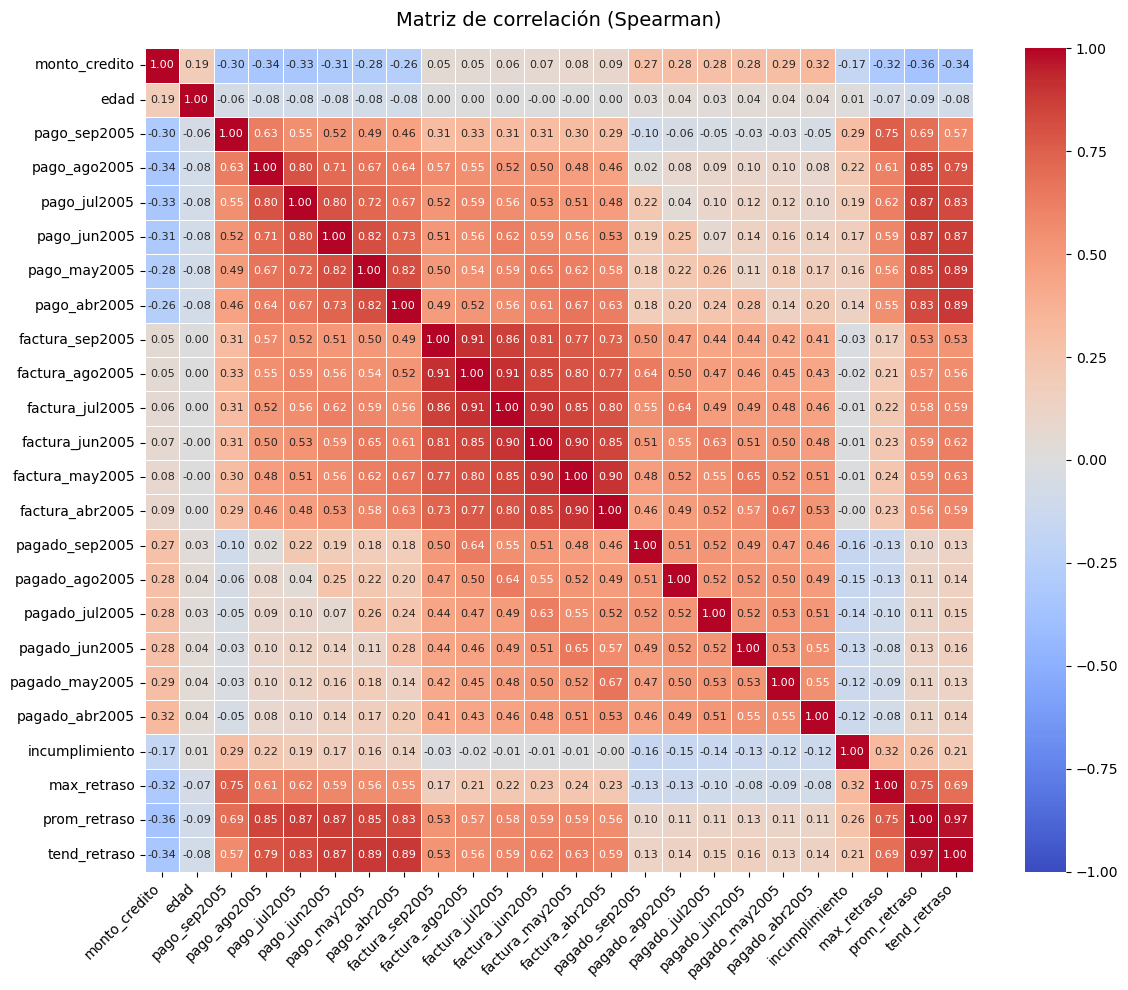

In [29]:
# Configuración de DataFrame para análisis de correlación

df = df_dccc.copy()
target = 'incumplimiento'
id_col = 'cliente_id'

# Seleccionando solo las columnas numéricas
num_df = df.select_dtypes(include='number').drop(columns=[id_col])

# Calculando matriz de correlación (Spearman recomendado)
corr = num_df.corr(method='spearman').round(2)


# Tamaño de la figura proporcional al nº de variables
fig, ax = plt.subplots(figsize=(12, 10))

# Heatmap con una paleta divergente centrada en 0
sns.heatmap(
    corr,
    cmap='coolwarm',
    center=0,
    vmin=-1, vmax=1,
    linewidths=0.5,
    annot=True,
    fmt='.2f',
    annot_kws={"size":8}
)

# Estética general
plt.title('Matriz de correlación (Spearman)', fontsize=14, pad=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
